# Dependencies

In [12]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sfp_nsdsyn.two_dimensional_model as two_d
import sfp_nsdsyn.cross_validation_2d_model as cv2d
import sfp_nsdsyn.visualization.plot_2D_model_results as vis2D
import sfp_nsdsyn.utils as utils
import warnings
import json
import matplotlib as mpl
from itertools import product

# Load the JSON file
with open("../config.json", "r") as file:
    config = json.load(file)
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Environment

In [3]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
dset='nsdsyn'
subj='subj01'
roi='V1'
vs='pRFsize'
max_epoch=30000
lr=0.0005
model_type_list = [1,2,3,4,5,6,7]
subj_list = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']

# Load in cross-validation results

In [4]:
loss_df = pd.DataFrame({})
for subj in subj_list:
    tmp = pd.DataFrame({})
    train_loss = pd.read_hdf(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/results_2D/nsdsyn/corrected/loss-history_lr-0.0005_eph-30000_sub-{subj}_roi-V1_vs-pRFsize.h5')
    tmp = pd.DataFrame({'subj': [subj], 
                        'model_type': 'train',
                        'loss': [train_loss.query('epoch == @max_epoch-1')['loss'].item()]})
    for model_type in model_type_list:
        test_loss = np.load(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/cross_validation/nsdsyn/model-{model_type}/cvlosses_bts-False_lr-0.0005_eph-30000_sub-{subj}_roi-V1_vs-pRFsize.npy')
        tmp = pd.concat([tmp, pd.DataFrame({'subj': [subj], 
                                            'model_type': [model_type],
                                            'loss': [test_loss.mean()]})], axis=0)
    loss_df = pd.concat([loss_df, tmp], axis=0, ignore_index=True)

# Plot cross-validation loss

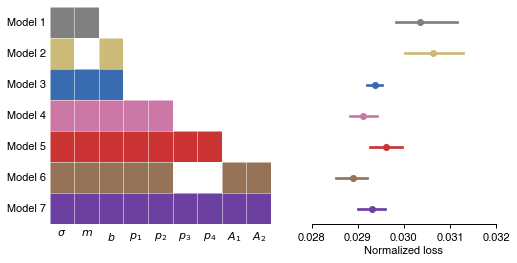

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1.2, 1]})
cv2d.show_model_type(data=None, ax=axes[0])
custom_palette = sns.color_palette([
    (0.50, 0.50, 0.50),
    (0.80, 0.73, 0.47),
    (0.22, 0.42, 0.69),
    (0.80, 0.47, 0.65),
    (0.80, 0.20, 0.20),
    (0.59, 0.45, 0.34),
    (0.42, 0.25, 0.63)
])
save_path = config['OUTPUT_DIR'] + 'figures/cross_validation/' + 'model_comparison.svg'
normalized_df = cv2d.normalize_loss_across_model(loss_df, add_mean=True, match_broderick=True)
cv2d.plot_model_comparison(normalized_df.query('model_type != "train"'),
                           ax=axes[1], 
                           y='model_type', 
                           x='normalized_loss', 
                           hue='model_type',
                           palette=custom_palette,
                           xlim=(0.028, 0.032),
                           save_path=save_path, **{'scale': 0.8})



# Load in cross-validation model params

In [7]:
model_df = pd.DataFrame({})
for subj, model_type in product(subj_list, model_type_list):
    tmp = pd.read_csv(os.path.join(config['OUTPUT_DIR'],'sfp_model',
                                   'cross_validation',
                                   f'{dset}',
                                   f'model-{model_type}',
                                   f'cvresults_bts-False_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vs}.csv'))
    tmp['sub'] = subj
    tmp['model_type'] = model_type
    model_df = pd.concat([model_df, tmp], axis=0)

# Load in precision values

In [8]:
nsd_precision_s =  pd.read_csv(f'/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision/precision-s_dset-nsdsyn_vs-pRFsize.csv')
nsd_precision_s = nsd_precision_s.query('vroinames == "V1"')
model_df = pd.merge(model_df, nsd_precision_s[['sub','precision']], on=['sub'])

In [9]:
model_avg_df = model_df.groupby(['model_type', 'sub']).mean().reset_index()

# Plot parameter comparison across model

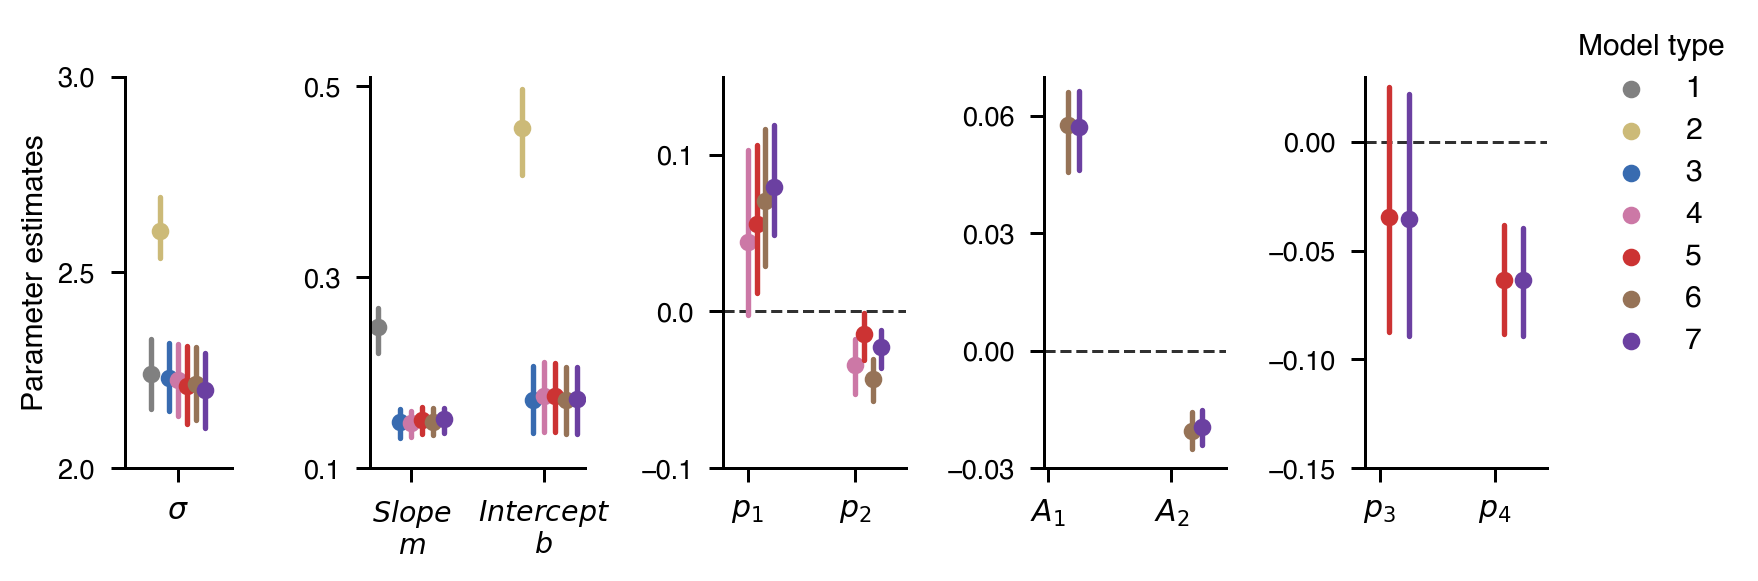

In [11]:
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1','A_2'], ['p_3','p_4']]
save_path = config['OUTPUT_DIR'] + 'figures/cross_validation/' + 'model_comparison_params_weighted_average.svg'
#ylim_list = [(1, 3), (0, 0.43), (-0.2, 0.2),(-0.1,0.1), (-0.2, 0.2)]
#yticks_list=  [[1,2,3], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1], [-0.2,0,0.2]]

ylim_list = [(2, 3), (0.1, 0.51), (-0.1, 0.15),(-0.03,0.07), (-0.15, 0.03)]
yticks_list=  [[2,2.5,3], [0.1, 0.3, 0.5], [-0.1,0,0.1], [-0.03,0,0.03, 0.06], [-0.15,-0.1,-0.05,0]]
vis2D.plot_model_comparison_params(model_avg_df, params_list, 
                                    hue='model_type', ylim=ylim_list, yticks=yticks_list,
                                    hue_order = model_type_list,
                                    weighted_average=True,
                                    save_path=save_path,
                                    **{'palette': custom_palette})#

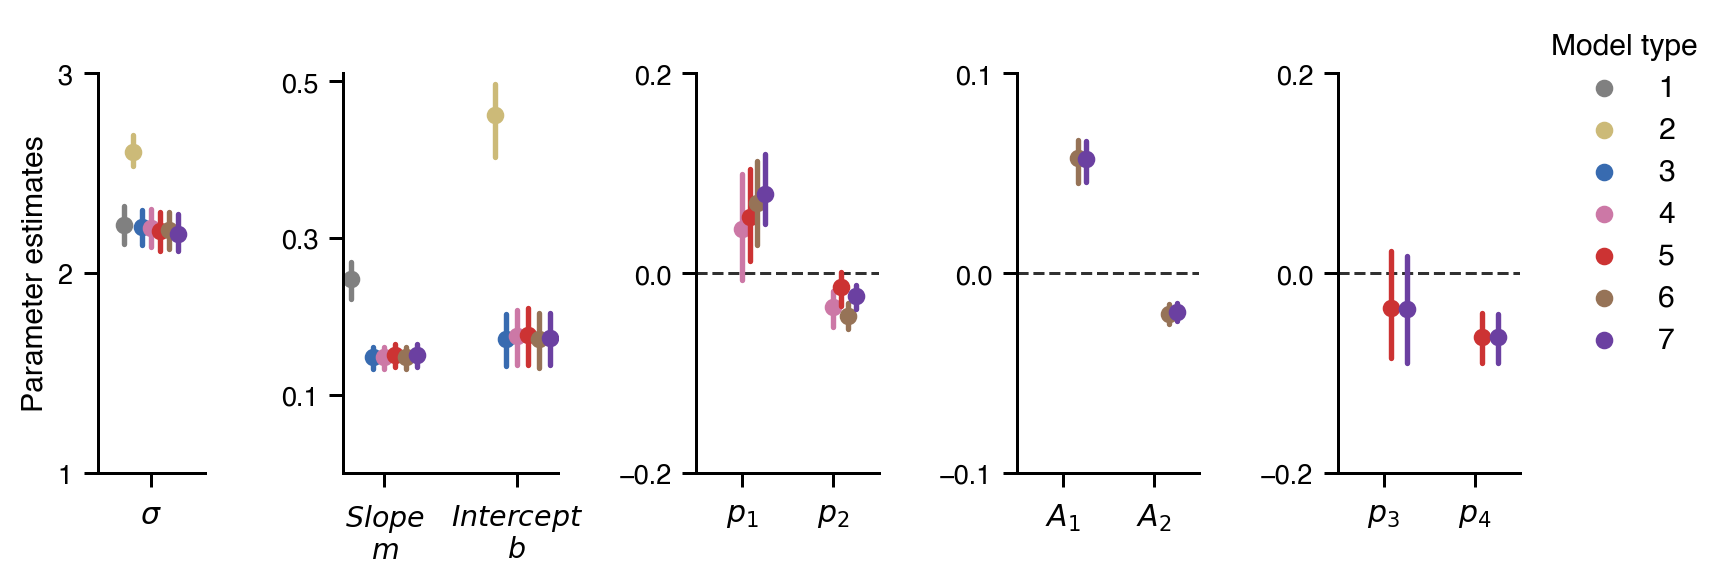

In [22]:
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1','A_2'], ['p_3','p_4']]
save_path = config['OUTPUT_DIR'] + 'figures/cross_validation/' + 'model_comparison_params_weighted_average.svg'
ylim_list = [(1, 3), (0, 0.51), (-0.2, 0.2),(-0.1,0.1), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0.1, 0.3, 0.5], [-0.2,0,0.2], [-0.1,0,0.1], [-0.2,0,0.2]]

vis2D.plot_model_comparison_params(model_avg_df, params_list, 
                                    hue='model_type', ylim=ylim_list, yticks=yticks_list,
                                    hue_order = model_type_list,
                                    weighted_average=True,
                                    save_path=save_path,
                                    **{'palette': custom_palette})


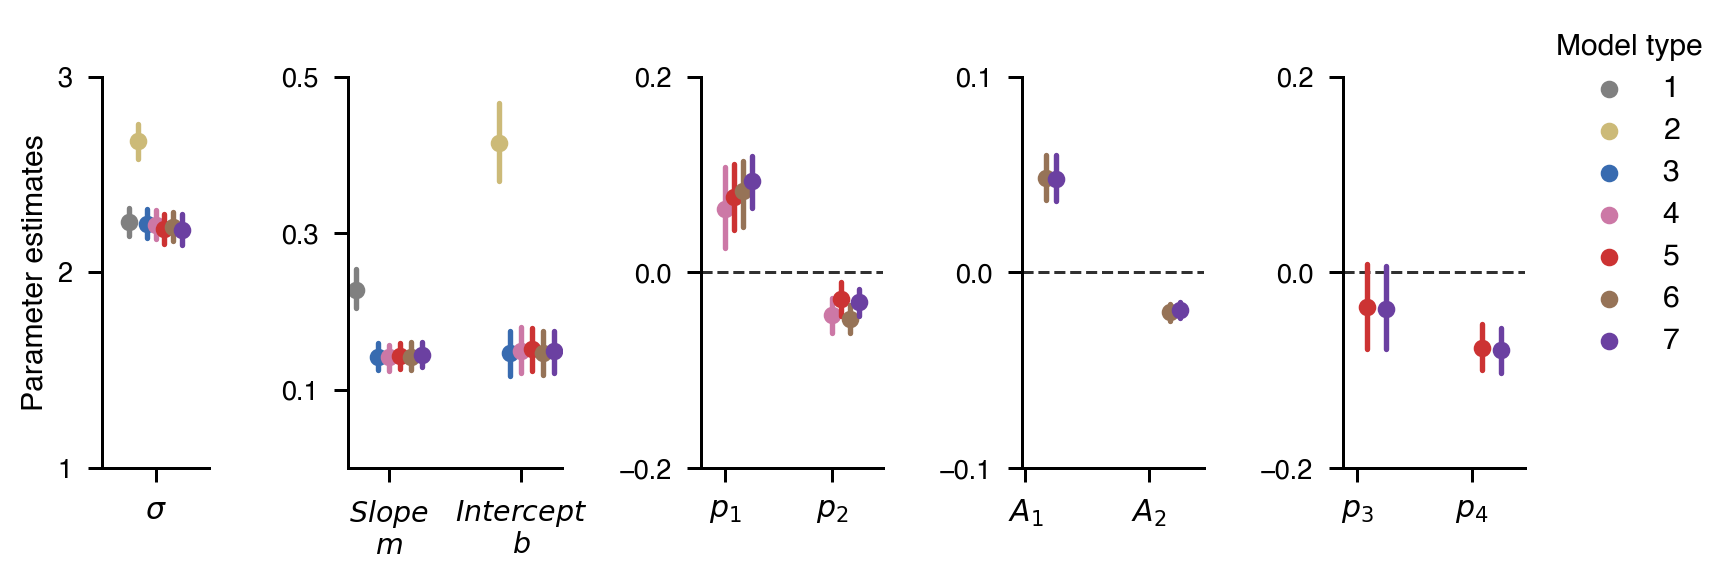

In [16]:
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1','A_2'], ['p_3','p_4']]
save_path = config['OUTPUT_DIR'] + 'figures/cross_validation/' + 'model_comparison_params_equal_average.svg'

#ylim_list = [(2, 3), (0.1, 0.51), (-0.1, 0.15),(-0.03,0.07), (-0.15, 0.03)]
#yticks_list=  [[2,2.5,3], [0.1, 0.3, 0.5], [-0.1,0,0.1], [-0.03,0,0.03, 0.06], [-0.15,-0.1,-0.05,0]]
ylim_list = [(1, 3), (0, 0.5), (-0.2, 0.2),(-0.1,0.1), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0.1, 0.3, 0.5], [-0.2,0,0.2], [-0.1,0,0.1], [-0.2,0,0.2]]

vis2D.plot_model_comparison_params(model_avg_df, params_list, 
                                    hue='model_type', ylim=ylim_list, yticks=yticks_list,
                                    hue_order= model_type_list,
                                    weighted_average=False,
                                    save_path=save_path,
                                    **{'palette': custom_palette})
